In [61]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [62]:
# create GEKKO model
m = GEKKO()

In [63]:
# constants
sm = 39.0 #maximal VO2
e0 = 2200 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
distance = 1000 #final horizontal distance to cover [m]

In [64]:
# time points [s]
nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

In [65]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

In [66]:
# slope data to create spline
x_data = np.linspace(0, distance, 500)
slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

In [67]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=10.0) #velocity
E = m.Var(value=e0, lb=0.0) #energy
x = m.Var(value=0.0) #horizontal coordinate
t = m.Var(value=0.0, lb=0.0) #time representative
sigma = m.Var(value=sm, lb=0) #breathing rate
sigma_max = m.Var() #limit of sigma value
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [68]:
# FV
tf = m.FV(value=150.0,lb=0.1,ub=300.0)
tf.STATUS = 1

In [69]:
# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

In [70]:
# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

# nutrition
nutrition = m.Intermediate((-0.01491*m.atan(-1.801*10**(-6)*(100*tf*t)**(1.696))+0.000741))

In [71]:
# equations
m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v + nutrition)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(t.dt()==1)
m.Equation(sigma<=sigma_max)
m.Equation((distance-x)*final<=0)

In [72]:
# objective
m.Minimize(tf)

In [73]:
m.options.IMODE = 6
m.options.MAX_ITER=1000
m.solve()

print('Final Time: ' + str(tf.value[0]))

apm 90.156.80.122_gk_model3 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           12
   Intermediates:            1
   Connections  :            4
   Equations    :            8
   Residuals    :            7
 
 Number of state variables:           1801
 Number of total equations: -         1600
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

  84  2.4140279e+04 8.89e+03 6.51e+06  12.0 8.11e+11    -  5.00e-08 3.73e-08f  1
  85  2.4140153e+04 8.89e+03 4.22e+14  12.0 2.00e-03  17.3 9.90e-01 1.00e+00f  1
  86  2.3832324e+04 7.71e+03 3.50e+14  11.3 7.55e+03    -  1.65e-01 1.33e-01h  1
  87  2.3845368e+04 6.49e+03 2.84e+14  10.6 8.41e+03    -  1.87e-01 1.57e-01h  1
  88  2.4098040e+04 6.04e+03 2.65e+14  10.0 1.17e+04    -  6.83e-02 6.83e-02h  1
  89  2.4496383e+04 5.67e+03 2.56e+14   9.3 1.09e+04    -  3.20e-02 6.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.4974518e+04 5.40e+03 2.31e+14   8.6 9.76e+03    -  9.74e-02 4.75e-02h  1
  91  2.4727587e+04 4.49e+03 2.01e+14   7.9 7.84e+03    -  1.31e-01 1.78e-01h  1
  92  2.4728407e+04 4.49e+03 2.20e+13   7.2 2.03e-04  16.9 9.38e-01 1.00e+00f  1
  93  2.4732219e+04 4.49e+03 1.56e+13   6.5 6.23e-04  16.4 8.84e-01 1.00e+00f  1
  94  2.4749552e+04 4.49e+03 1.56e+13   5.8 1.97e-03  15.9 4.53e-01 1.00e+00f  1
  95  2.4824786e+04 4.50e+03

 173  1.7556867e+04 3.51e+02 1.32e+09   4.6 3.09e+01   5.2 1.00e+00 1.00e+00h  1
 174  1.7651369e+04 3.54e+02 7.00e+10   3.2 2.00e-02  13.0 1.00e+00 1.00e+00h  1
 175  1.7657890e+04 3.24e+02 1.46e+10   2.2 3.95e-03  12.6 1.00e+00 1.00e+00h  1
 176  1.7656402e+04 3.01e+02 3.05e+10   0.6 3.09e-03  13.0 1.00e+00 1.00e+00h  1
 177  1.7656567e+04 2.81e+02 2.04e+11  -1.1 2.62e-03  13.4 1.00e+00 1.00e+00h  1
 178  1.7657314e+04 1.76e+02 1.23e+11  -2.5 1.43e-02  12.9 1.00e+00 9.61e-01h  1
 179  1.7657313e+04 1.75e+02 1.23e+11  -4.1 2.47e-02  12.5 1.00e+00 2.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.7657311e+04 1.75e+02 1.23e+11  -5.4 4.44e-02  12.0 1.00e+00 1.19e-03h  1
Scaling factors are invalid - setting them all to 1.
 181r 1.7657311e+04 1.75e+02 1.00e+03   1.5 0.00e+00  11.5 0.00e+00 2.21e-08R  8
 182r 1.7727961e+04 6.71e+01 3.11e+03   0.2 4.64e+03    -  1.58e-02 6.81e-03f  1
 183  1.8002977e+04 1.18e+02 5.90e+02   5.8 7.68e+08    

 247  2.0633534e+04 1.82e+02 1.96e+09   3.3 5.39e-01   9.2 1.00e+00 1.00e+00f  1
 248  2.0514403e+04 9.79e+01 1.44e+09   3.3 4.73e-01   8.7 1.00e+00 1.00e+00f  1
 249  2.0408881e+04 1.95e+01 2.83e+08   3.3 6.82e-01   8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  2.0436382e+04 1.64e+01 1.77e+08   3.3 1.16e-01   7.7 1.00e+00 3.70e-01h  1
 251  2.0552906e+04 5.74e+00 7.79e+07   3.3 2.86e-01   7.3 1.00e+00 1.00e+00F  1
 252  2.0731247e+04 8.11e+00 2.14e+07   2.6 8.23e-01   6.8 9.78e-01 1.00e+00H  1
 253  2.0757847e+04 5.21e+00 1.67e+07   1.9 1.33e+00   6.3 1.00e+00 2.50e-01h  3
 254  2.0737975e+04 4.71e+00 1.54e+07   1.9 1.95e+00   5.8 1.00e+00 7.99e-02h  4
 255  2.0686864e+04 4.40e+00 1.46e+07   1.9 3.50e+00   5.3 1.00e+00 5.20e-02h  4
 256  2.0645152e+04 4.27e+00 1.43e+07   1.9 1.01e+01   4.9 1.00e+00 2.17e-02h  5
 257  2.0596718e+04 4.16e+00 1.41e+07   1.9 2.67e+01   4.4 1.00e+00 1.68e-02h  5
 258  2.0557754e+04 4.09e+00

 341  2.3809742e+04 1.04e+00 6.30e+08   0.5 4.91e+00   5.9 1.00e+00 1.00e+00h  1
 342  2.3845476e+04 8.49e-01 5.53e+08   0.5 2.16e+00   6.3 1.00e+00 1.25e-01h  4
 343  2.3861424e+04 8.46e-01 5.44e+08   0.5 6.50e+00   5.8 1.00e+00 1.56e-02h  7
 344  2.3922625e+04 8.34e-01 4.15e+08   0.5 2.47e+00   6.2 1.00e+00 2.50e-01h  3
 345  2.3951782e+04 8.24e-01 3.89e+08   0.5 7.57e+00   5.8 1.00e+00 6.25e-02h  5
 346  2.4006959e+04 7.99e-01 2.10e+08   0.5 2.90e+00   6.2 1.00e+00 5.00e-01h  2
 347  2.4024554e+04 7.80e-01 2.34e+07   0.5 1.16e+00   6.6 1.00e+00 1.00e+00h  1
 348r 2.4024554e+04 7.80e-01 1.00e+03   0.5 0.00e+00   6.1 0.00e+00 4.77e-07R 22
 349r 2.3640988e+04 5.61e+00 1.51e+03   1.8 3.07e+03    -  5.19e-02 2.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  2.3584829e+04 5.23e+00 2.30e+03   0.5 5.82e+02    -  9.35e-01 2.11e-02h  6
 351  2.3544784e+04 4.92e+00 4.70e+03   0.5 6.34e+02    -  9.90e-01 1.56e-02h  7
 352  2.3531901e+04 4.90e+00

Final Time: 148.89141917


In [74]:
tm = tm * tf.value[0]

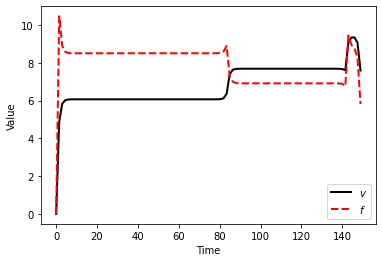

In [75]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

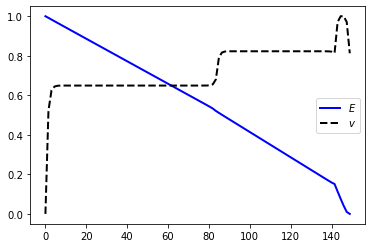

In [76]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.legend()
plt.show()

In [77]:
nutrition.value

[0.000741, 0.0008710670526, 0.0011623175742, 0.0015783731222, 0.0021026401785, 0.0027228155758, 0.003427501443, 0.0042047919821, 0.0050416618359, 0.0059238738096, 0.0068362950133, 0.0077635172547, 0.0086906430983, 0.0096040760973, 0.010492167283, 0.011345620206, 0.012157624696, 0.012923750452, 0.013641668856, 0.014310781557, 0.014931824251, 0.015506494145, 0.016037128681, 0.016526446114, 0.016977347236, 0.017392771231, 0.017775596122, 0.018128574039, 0.018454292547, 0.018755154758, 0.019033372498, 0.019290968213, 0.019529782409, 0.019751484385, 0.019957584664, 0.020149448065, 0.02032830672, 0.020495272596, 0.020651349272, 0.020797442839, 0.020934371862, 0.021062876435, 0.021183626334, 0.021297228341, 0.021404232799, 0.021505139466, 0.021600402734, 0.02169043628, 0.021775617203, 0.021856289713, 0.021932768413, 0.022005341223, 0.022074271986, 0.022139802797, 0.022202156076, 0.022261536427, 0.022318132295, 0.022372117457, 0.022423652353, 0.022472885284, 0.022519953485, 0.0225649841, 0.022